In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from scipy import sparse
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Dataset/9_Donors_choose_DT/preprocessed_data.csv')

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#importing nltk SentimentIntensityAnalyzer to analysis sentiment values
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#creating instance for SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
#getting essay values from dataset
e = data['essay'].values

In [ ]:
#calculate sentiment values for essay and sum and store in list using list comprehensive
lst = [sum(sid.polarity_scores(e[i]).values()) for i in range(len(data))]

In [ ]:
#adding new column to dataset as po contains sum of sentiment values
data['po'] = np.array(lst)

In [ ]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'po'],
      dtype='object')

In [ ]:
#define x and y values
x = data.drop(['project_is_approved'], axis=1)
y = data['project_is_approved'].values

In [ ]:
#splitting data to train and test using train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, stratify = y)

In [ ]:
#response coding function
def response_cod(x_train, y_train, feature):
  #creating empty dictionary
  dictionary = dict()
  #getting uniqui values from x_train data
  unique_features = x_train[feature].unique()
  #iterating through unique_features
  for i in range(len(unique_features)):

    #calculate count of each unique_features
    t_count = x_train.loc[:,feature][(x_train[feature] == unique_features[i])].count()

    #getting probability value of class label = 0 and 1
    p_0 = x_train.loc[:,feature][((x_train[feature] == unique_features[i]) & (y_train == 0))].count()
    p_1 = x_train.loc[:,feature][((x_train[feature] == unique_features[i]) & (y_train == 1))].count()

    #adding those probability values of unique_values into dictionary as key value pair
    dictionary[unique_features[i]] = [p_0/t_count, p_1/t_count]
  #calculate values count of features
  value_count = x_train[feature].value_counts()
  #creating empty list
  lst = []

  #iterate through index and row of x_train
  for index, row in x_train.iterrows():
    #check the feature is available in value count dictionary 
    if row[feature] in dict(value_count).keys():
        #adding probability values of features to list
        lst.append(dictionary[row[feature]])
    else:
        #if feature not available in value count dictionary add 0.5 as probability values for both class label
        lst.append([1/2,1/2])

  #returing list
  return lst

In [ ]:
#create tfidfvectorizer with below parameters to encode essay
from sklearn.feature_extraction.text import TfidfVectorizer
TF = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=2500)

#fit using train data
TF.fit(x_train['essay'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=2500,
                min_df=10, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
#Transform train and test esaay values
x_train_essay_tfidf = TF.transform(x_train['essay'].values)
x_test_essay_tfidf = TF.transform(x_test['essay'].values)

In [ ]:
#standardizing teacher_number_of_previously_posted_projects as it is numerical features
std = StandardScaler()
std.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_train_nopp_std = std.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_nopp_std = std.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [ ]:
#standardizing price as it is numerical features
std = StandardScaler()
std.fit(x_train['price'].values.reshape(-1,1))

x_train_price_std = std.transform(x_train['price'].values.reshape(-1,1))
x_test_price_std = std.transform(x_test['price'].values.reshape(-1,1))

In [ ]:
#standardizing po as it is numerical features
std.fit(x_train['po'].values.reshape(-1,1))

x_train_po_std = std.transform(x_train['po'].values.reshape(-1,1))
x_test_po_std = std.transform(x_test['po'].values.reshape(-1,1))

In [ ]:
#encoding school state using response coding
x_train_school_state_res = np.array(response_cod(x_train, y_train, 'school_state'))
x_test_school_state_res = np.array(response_cod(x_test, y_test, 'school_state'))

In [ ]:
#encoding teacher_prefix using response coding
x_train_teacher_prefix_rescod = np.array(response_cod(x_train, y_train, 'teacher_prefix'))
x_test_teacher_prefix_rescod = np.array(response_cod(x_test, y_test, 'teacher_prefix'))

In [ ]:
#encoding project_grade_category using response coding
x_train_project_grade_category_rescod = np.array(response_cod(x_train, y_train, 'project_grade_category'))
x_test_project_grade_category_rescod = np.array(response_cod(x_test, y_test, 'project_grade_category'))

In [ ]:
#encoding clean_categories using response coding
x_train_clean_categories_rescod = np.array(response_cod(x_train, y_train, 'clean_categories'))
x_test_clean_categories_rescod = np.array(response_cod(x_test, y_test, 'clean_categories'))

In [ ]:
#encoding clean_subcategories using response coding
x_train_clean_subcategories_rescod = np.array(response_cod(x_train, y_train, 'clean_subcategories'))
x_test_clean_subcategories_rescod = np.array(response_cod(x_test, y_test, 'clean_subcategories'))

In [ ]:
x_tr = hstack((x_train_essay_tfidf, x_train_nopp_std, x_train_price_std, x_train_po_std, x_train_school_state_res, x_train_teacher_prefix_rescod, x_train_project_grade_category_rescod, x_train_clean_categories_rescod, x_train_clean_subcategories_rescod)).tocsr()
x_te = hstack((x_test_essay_tfidf, x_test_nopp_std, x_test_price_std, x_test_po_std, x_test_school_state_res, x_test_teacher_prefix_rescod, x_test_project_grade_category_rescod, x_test_clean_categories_rescod, x_test_clean_subcategories_rescod)).tocsr()

XGBoost

In [ ]:
from xgboost import XGBClassifier
#creating instance for XGBClassifier
xgbrs = XGBClassifier()

#setting parameters for hyperparameters tuning
param = {'n_estimators' : [8,16,32,64], 'max_depth' : [3,4,5,6]}

#Hyperparameter tuning using RandomizedSearchCV
rs2 = RandomizedSearchCV(xgbrs, param_distributions = param, cv=5, n_jobs=-1, return_train_score=True, scoring='roc_auc')

#fit with train data
rs2.fit(x_tr, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [ ]:
#getting best parameters and best score of model
print(rs2.best_params_)
print(rs2.best_score_)

{'n_estimators': 64, 'max_depth': 6}
0.7196402554382277


In [ ]:
#getting total result of model
result = pd.DataFrame.from_dict(rs2.cv_results_)

In [ ]:
#getting train and test AUC from result
train_auc= result['mean_train_score']
test_auc = result['mean_test_score']
print("Test Data AUC ", test_auc)

Test Data AUC  0    0.655878
1    0.662440
2    0.702157
3    0.683603
4    0.678121
5    0.716273
6    0.703828
7    0.661713
8    0.646117
9    0.719640
Name: mean_test_score, dtype: float64


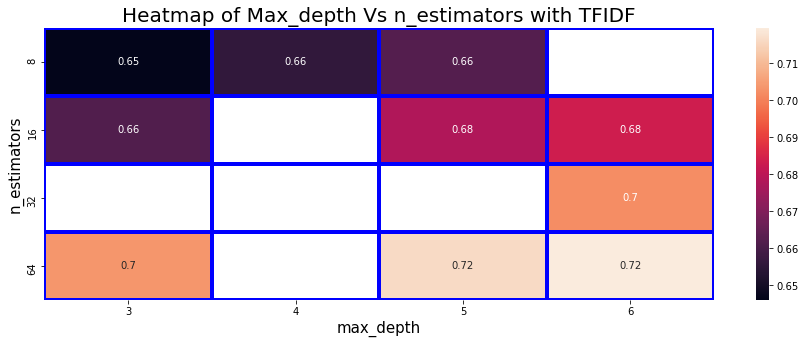

In [ ]:
pi = result.pivot('param_n_estimators', 'param_max_depth', 'mean_test_score')
plt.figure(figsize=(15,5))
sns.heatmap(pi, annot=True, linecolor='blue', linewidths=3)
plt.title('Heatmap of Max_depth Vs n_estimators with TFIDF', fontsize = 20) # title with fontsize 20
plt.xlabel('max_depth', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('n_estimators', fontsize = 15) # y-axis label with fontsize 15
plt.show()

In [ ]:
#creating best model for DecisionTreeClassifier with best parameters
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs = -1, n_estimators=rs2.best_params_.get('n_estimators'), max_depth=rs2.best_params_.get('max_depth'))

#fit with training data
xgb.fit(x_tr, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=64, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#predicting probability values for train and test data
y_train_pred_prob = xgb.predict_proba(x_tr)[:,1]
y_test_pred_prob = xgb.predict_proba(x_te)[:,1]

#finding false positive rate and true positive rate for train and test data
tr_fpr, tr_tpr, tr_thershold = roc_curve(y_train, y_train_pred_prob)
te_fpr, te_tpr,te_threshold = roc_curve(y_test, y_test_pred_prob)

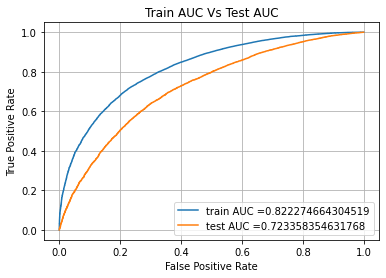

In [ ]:
#plotting ROC_AUC curve for train and test data
plt.figure(figsize=(15,5))
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr, te_tpr, label="test AUC ="+str(auc(te_fpr, te_tpr)))
plt.title('Train AUC Vs Test AUC with TFIDF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#predicting y values for train and test data
y_train_pred = xgb.predict(x_tr)
y_test_pred = xgb.predict(x_te)

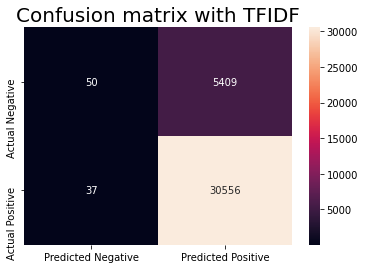

In [ ]:
#Heatmap confusion matrix between actual y_test and predicted y_test values
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True, fmt = 'd', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion matrix with TFIDF', fontsize = 20)
plt.show()

TFIDFW2V

In [ ]:
with open('/content/drive/My Drive/Dataset/9_Donors_choose_DT/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
#calculating TFIDF-W2V of train data
#getting train essay values
ee = x_train['essay'].values

#create empty list
res_tr = []
#iterating through each sentance in essay
for i in tqdm(range(len(ee))):
  #initialize numerator and denominator values to zero
  nume = deno = 0
  #iterating through each words in sentence
  for words in ee[i].split():
    #if word present in glove words get its TFIDF values from TF_dictionary and multiply with its 300_dim vector representation and store in numerator
    if words in glove_words:
      tfidf = (ee[i].count(words) / len(ee[i].split())) * (TF.vocabulary_.get(words, 0))
      nume += (tfidf * model[words])
      #summing the TFIDF values of each words and store it in denominator
      deno += tfidf

  #divide numerator and denominator and append to list
  res_tr.append(nume / deno)

#convert list to numpy array
x_train_essay_tfidfw2v = np.array(res_tr)

100%|██████████| 73196/73196 [03:09<00:00, 387.08it/s]


In [ ]:
#calculating TFIDF-W2V
#getting train essay values
te = x_test['essay'].values

#create empty list
res_te = []
#iterating through each sentance in essay
for i in tqdm(range(len(te))):
  #initialize numerator and denominator values to zero
  nume = deno = 0
  #iterating through each words in sentence
  for words in te[i].split():
    #if word present in glove words get its TFIDF values from TF_dictionary and multiply with its 300_dim vector representation and store in numerator
    if words in glove_words:
      tfidf_te = (te[i].count(words) / len(te[i].split())) * (TF.vocabulary_.get(words, 0))
      nume += (tfidf_te * model[words])
      #summing the TFIDF values of each words and store it in denominator
      deno += tfidf_te

  #divide numerator and denominator and append to list
  res_te.append(nume / deno)

#convert list to numpy array
x_test_essay_tfidfw2v = np.array(res_te)

100%|██████████| 36052/36052 [01:33<00:00, 386.80it/s]


In [ ]:
#merging all encoded features into one using horizontal stacking
x_tr2 = sparse.csr_matrix(np.hstack((x_train_essay_tfidfw2v, x_train_nopp_std, x_train_price_std, x_train_po_std, x_train_school_state_res, x_train_teacher_prefix_rescod, x_train_project_grade_category_rescod, x_train_clean_categories_rescod, x_train_clean_subcategories_rescod)))
x_te2 = sparse.csr_matrix(np.hstack((x_test_essay_tfidfw2v, x_test_nopp_std, x_test_price_std, x_test_po_std, x_test_school_state_res, x_test_teacher_prefix_rescod, x_test_project_grade_category_rescod, x_test_clean_categories_rescod, x_test_clean_subcategories_rescod)))

In [ ]:
#creating instance for XGBClassifier
xgbrs3 = XGBClassifier()

#setting parameters for hyperparameters tuning
param = {'n_estimators' : [8,16,32,64], 'max_depth' : [3,4,5,6]}

#Hyperparameter tuning using RandomizedSearchCV
rs3 = RandomizedSearchCV(xgbrs3, param_distributions = param, cv=5, n_jobs=-1, return_train_score=True, scoring='roc_auc')

#fit with train data
rs3.fit(x_tr2, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [ ]:
#getting best parameters and best score of model
print(rs3.best_params_)
print(rs3.best_score_)

{'n_estimators': 64, 'max_depth': 4}
0.6764479592118505


In [ ]:
#getting total result of model
result = pd.DataFrame.from_dict(rs3.cv_results_)

In [ ]:
#getting train and test AUC from result
train_auc= result['mean_train_score']
test_auc = result['mean_test_score']
print("Test Data AUC ", test_auc)

Test Data AUC  0    0.667635
1    0.676448
2    0.645133
3    0.643031
4    0.655883
5    0.652782
6    0.662654
7    0.641046
8    0.629581
9    0.672685
Name: mean_test_score, dtype: float64


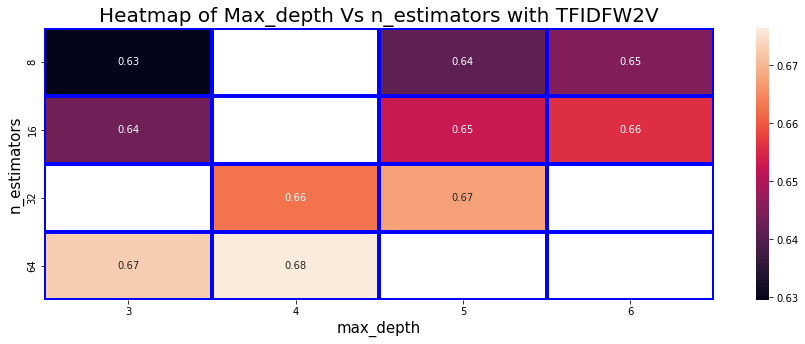

In [ ]:
pi2 = result.pivot('param_n_estimators', 'param_max_depth', 'mean_test_score')
plt.figure(figsize=(15,5))
sns.heatmap(pi2, annot=True, linecolor='blue', linewidths=3)
plt.title('Heatmap of Max_depth Vs n_estimators with TFIDFW2V', fontsize = 20) # title with fontsize 20
plt.xlabel('max_depth', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('n_estimators', fontsize = 15) # y-axis label with fontsize 15
plt.show()

In [ ]:
#creating best model for XGBClassifier with best parameters
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs = -1, n_estimators=rs3.best_params_.get('n_estimators'), max_depth=rs3.best_params_.get('max_depth'))
#,subsample=0.5, colsample_bytree=0.5

#fit with training data
xgb.fit(x_tr2, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=64, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#predicting probability values for train and test data
y_train_pred_prob = xgb.predict_proba(x_tr2)[:,1]
y_test_pred_prob = xgb.predict_proba(x_te2)[:,1]

#finding false positive rate and true positive rate for train and test data
tr_fpr3, tr_tpr3, tr_thershold = roc_curve(y_train, y_train_pred_prob)
te_fpr3, te_tpr3,te_threshold = roc_curve(y_test, y_test_pred_prob)

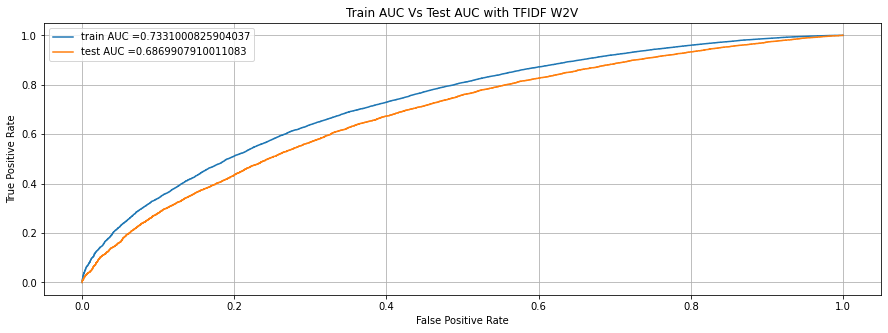

In [ ]:
#plotting ROC_AUC curve for train and test data
plt.figure(figsize=(15,5))
plt.plot(tr_fpr3, tr_tpr3, label="train AUC ="+str(auc(tr_fpr3, tr_tpr3)))
plt.plot(te_fpr3, te_tpr3, label="test AUC ="+str(auc(te_fpr3, te_tpr3)))
plt.title('Train AUC Vs Test AUC with TFIDF W2V')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#predicting y values for train and test data
y_train_pred = xgb.predict(x_tr2)
y_test_pred = xgb.predict(x_te2)

Text(0.5, 1.0, 'Confusion matrix with TFIDF-W2V')

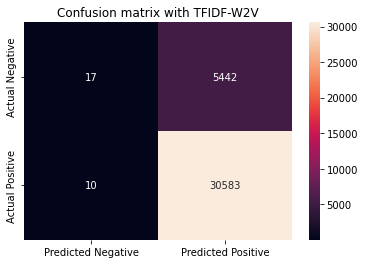

In [ ]:
#Heatmap confusion matrix between actual y_test and predicted y_test values
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True, fmt = 'd', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion matrix with TFIDF-W2V')

In [2]:
from prettytable import PrettyTable
x=PrettyTable()

x.field_names=['Vectorizer', 'Model', 'Hyperparameter', 'AUC']
x.add_row(['Random Search-TFIDF', "XGBoost", len(rs2.best_params_.keys()), round(rs2.best_score_,3)])
x.add_row(['TFIDF', "XGBoost", len(rs2.best_params_.keys()), round(auc(te_fpr, te_tpr), 3)])
x.add_row(['Random Search-TFIDFW2V', "XGBoost", len(rs3.best_params_.keys()), round(rs3.best_score_,3)])
x.add_row(['TFIDFW2V', "XGBoost", len(rs3.best_params_.keys()), round(auc(te_fpr3, te_tpr3), 3)])

print(x)

+------------------------+---------+----------------+-------+
|       Vectorizer       |  Model  | Hyperparameter |  AUC  |
+------------------------+---------+----------------+-------+
|  Random Search-TFIDF   | XGBoost |       2        | 0.719 |
|         TFIDF          | XGBoost |       2        | 0.723 |
| Random Search-TFIDFW2V | XGBoost |       2        | 0.676 |
|        TFIDFW2V        | XGBoost |       2        | 0.686 |
+------------------------+---------+----------------+-------+
